## 3. Data Cleaning & EDA

In [1]:
# imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist

In [2]:
# load collected data
subreddit_content = pd.read_csv('../dataset/subreddit_content.csv')

subreddit_content.head()

,subreddit,post_content,upvote_ratio
0,statistics,"Hello everyone!\n\nFirstly, please let me know...",1.00
1,statistics,It would be great if the numbers are from 2022...,0.33
2,statistics,"Hi, I would like to know what sort of approach...",0.67
3,statistics,I recently got a job offer for a chemistry ass...,0.76
4,statistics,I am a foreign student in the United States of...,0.65


### a. Data Cleaning

#### Missing values

In [3]:
# check for missing entries
subreddit_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     1830 non-null   object 
 1   post_content  1829 non-null   object 
 2   upvote_ratio  1830 non-null   float64
dtypes: float64(1), object(2)
memory usage: 43.0+ KB


A null value is identified in the 'post_content' column. Since only one record is affected out of 1830 records and the fact that the values under 'post_content' column is critical for analysis, the value should not be imputed and the entire row of record would thus be dropped.

In [4]:
# drop row with null value
subreddit_content.dropna(inplace = True)

# verify removal of record
subreddit_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1829 entries, 0 to 1829
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     1829 non-null   object 
 1   post_content  1829 non-null   object 
 2   upvote_ratio  1829 non-null   float64
dtypes: float64(1), object(2)
memory usage: 57.2+ KB


#### Convert all letters to lower cap for 'subreddit' and 'post_content' columns

In [5]:
# define function for the conversion
def lowercase_conversion(column_name):
    subreddit_content[column_name] = subreddit_content[column_name].str.lower()

In [6]:
# convert for 'subreddit' column
lowercase_conversion('subreddit')

# convert for 'post_content' column
lowercase_conversion('post_content')

#### Remove irrelevant characters, special symbols, URL, etc in 'post_content' column

In [7]:
# define function to remove url
def remove_url(value):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return re.sub(url_pattern, '', value)

# remove url
subreddit_content['post_content'] = subreddit_content['post_content'].apply(remove_url)

In [8]:
# remove newline characters
subreddit_content['post_content'] = subreddit_content['post_content'].str.replace('\n', ' ', regex = True)

# remove special characters
subreddit_content['post_content'] = subreddit_content['post_content'].str.replace('[^\w\s]', '', regex = True)

#### Tokenization, lemmatization and removal of english stop words

In [9]:
# instantiate WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# get list of stopwords
stopwords_list = stopwords.words('english')

# tokenize, lemmatize and remove stop words
subreddit_content['post_content'] = subreddit_content['post_content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x) if word.lower() not in stopwords_list]))

subreddit_content.head()

,subreddit,post_content,upvote_ratio
0,statistics,hello everyone firstly please let know post be...,1.00
1,statistics,would great number 2022 anyone know find tried...,0.33
2,statistics,hi would like know sort approach used best for...,0.67
3,statistics,recently got job offer chemistry assistant job...,0.76
4,statistics,foreign student united state america completed...,0.65


### b. EDA

#### Summary statistics

In [10]:
subreddit_content.groupby('subreddit').describe()

upvote_ratio                                                 
                       count      mean       std   min   25%   50%   75%  max
subreddit                                                                    
machinelearning        859.0  0.749406  0.221121  0.07  0.64  0.82  0.92  1.0
statistics             970.0  0.829918  0.206232  0.10  0.73  0.91  1.00  1.0

The upvote ratio measures the ratio (or percentage) of upvotes received by the posts against the total number of votes received. In this case, the mean ratio for both the machine learning and statistics posts are around 0.75 to 0.83 respectively which are both rather healthy ratio numbers. This indicates that the posts which have been scraped are generally of relatively good standing in terms of content on the respective subreddit commmunities.

#### Topic 1: Statistics

i. Outlier analysis (by analysing word frequency for the 50 most used words)

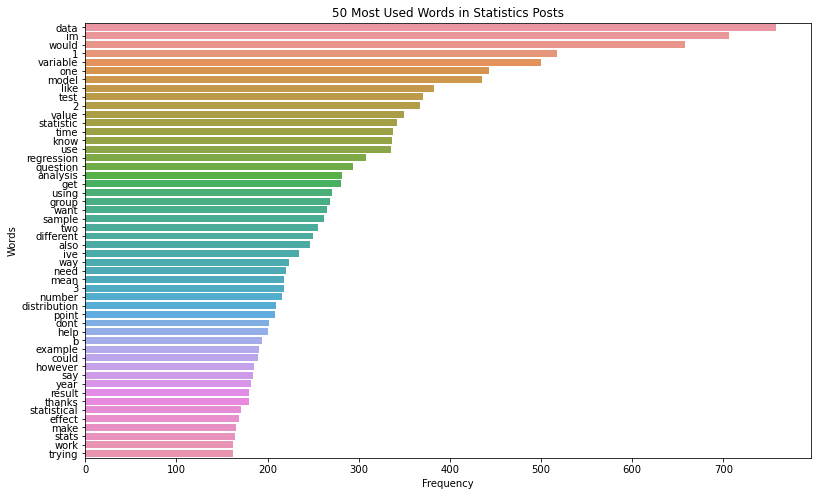

In [11]:
# extract words from 'post_content' column
stats_content = subreddit_content[subreddit_content['subreddit'] == 'statistics']['post_content'].str.split().tolist()
stats_words = [word for sublist in stats_content for word in sublist]

# calculate frequency
stats_word_freq = FreqDist(stats_words)

# convert frequency distribution to df
stats_freq_df = pd.DataFrame({'Word': list(stats_word_freq.keys()), 'Frequency': list(stats_word_freq.values())})

# sort df by frequency in descending order
sorted_stats_df = stats_freq_df.sort_values(by = 'Frequency', ascending = False)

# plot word frequency countplot
plt.figure(figsize=(13, 8))
sns.barplot(x = 'Frequency', y = 'Word', data = sorted_stats_df.head(50))
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('50 Most Used Words in Statistics Posts')
plt.show()

Based on the above analysis of 50 most used words in the scraped statistics posts, it is observed that there are quite a few words which do not have any actual meaning (e.g., im, would, wa) or are not contextually related to the topic of statistics (e.g., like, know, thanks). Thus, these words would be removed to avoid affecting the subsequent model training in view of the high frequency of use.

At the same time, we can also observe that common words used in these posts touch on aspects related to statistical analysis such as 'variable', 'regression', 'sample', 'distribution', 'mean', 'statistical', 'statistic', 'stats'.

In [12]:
# define list of stopwords
stats_stopwords = ['im', 'would', 'like', 'wa', 'know', 'get', 'want', 'ha', 'ive', 'need', 'dont', 'b', 'help', 'could', 'however', 'say', 'thanks', 'trying', 'work']

# define function to remove stopwords
def remove_stats_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stats_stopwords]
    return ' '.join(filtered_words)

# apply function to 'post_content' column
stats_mask = subreddit_content['subreddit'] == 'statistics'
subreddit_content.loc[stats_mask, 'post_content'] = subreddit_content.loc[stats_mask, 'post_content'].apply(remove_stats_stopwords)

ii. Outlier analysis (by reviewing words with low word frequency)

In [17]:
# number of words under each word frequency
stats_value_counts = sorted_stats_df['Frequency'].value_counts()

# filter and print value counts greater than 1
filtered_stats_value_counts = stats_value_counts[stats_value_counts > 100]
                      
filtered_stats_value_counts

1    4499
2    1243
3     624
4     408
5     296
6     215
7     185
8     166
9     123
Name: Frequency, dtype: int64

By reviewing the value counts of the 'Frequency' column, there is a decreasing trend as the number of occurence of the word increases which is an expected trend as the words used by different individuals vary and would only have overlaps to a certain extent. However, we see that there are drastic drops in the value counts between words that occurs (1) once versus twice and (2) twice versus thrice in all of the statistics post, before smoothening out to a more gentle decreasing rate.

In [18]:
sorted_stats_df[sorted_stats_df['Frequency'] < 3].sort_values(by = 'Word')

,Word,Frequency
5650,000,2
5570,00000,1
8932,0000000000,1
8931,0000005,1
4269,0000192,1
...,...,...
8202,β0β1_xi1βp_xip,1
6455,εiid,1
810,ρ,1
4347,χ2,1


Words which only appears once or twice in all of the posts are likely to not be meaningful for model training due to the extremely low occurence. Thus, these words are filtered and sorted as above to check that it concurs with the earlier proposition that they lack contextual relation to the statistics topic. From here, they would be removed to avoid affecting the subsequent model training.

In [19]:
# define words to remove
stats_words_to_remove = sorted_stats_df[sorted_stats_df['Frequency'] < 3]['Word'].tolist()

def remove_stats_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stats_words_to_remove]
    return ' '.join(filtered_words)

subreddit_content.loc[subreddit_content['subreddit'] == 'statistics', 'post_content'] = subreddit_content.loc[subreddit_content['subreddit'] == 'statistics', 'post_content'].apply(remove_stats_words)

iii. Post length analysis

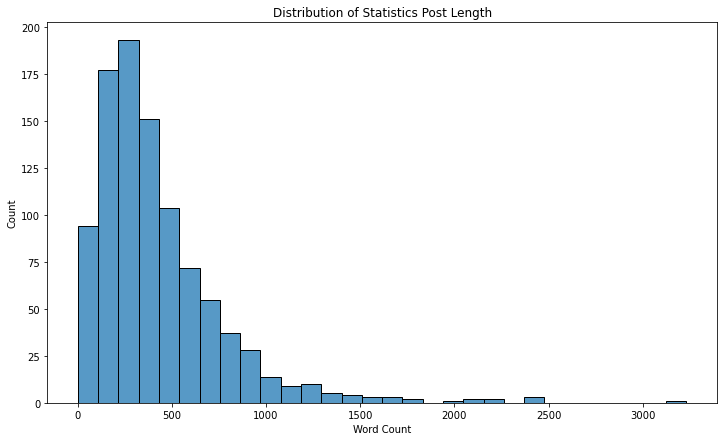

In [20]:
stats_content = subreddit_content[subreddit_content['subreddit'] == 'statistics']

# calculate post length
stats_post_length = []

for post in stats_content['post_content']:
    stats_post_length.append(len(post))

# plot histogram
plt.figure(figsize = (12, 7))
sns.histplot(stats_post_length, bins = 30)
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Distribution of Statistics Post Length')
plt.show()

The distribution of the post length for the statistics topic is observed to be positively-skewed, where most posts have a word count of about 200 to 900 words.

#### Topic 2: Machine learning

i. Outlier analysis (by analysing word frequency for the 50 most used words)

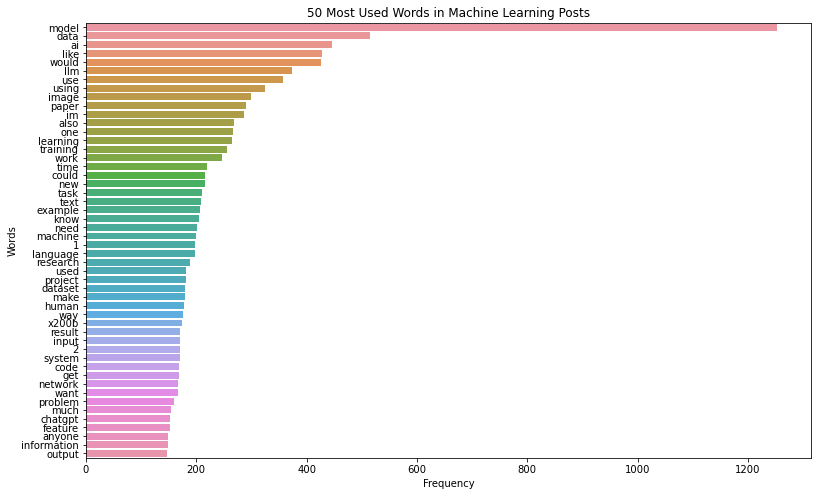

In [21]:
# extract words from 'post_content' column
ml_content = subreddit_content[subreddit_content['subreddit'] == 'machinelearning']['post_content'].str.split().tolist()
ml_words = [word for sublist in ml_content for word in sublist]

# calculate frequency
ml_word_freq = FreqDist(ml_words)

# convert frequency distribution to df
ml_freq_df = pd.DataFrame({'Word': list(ml_word_freq.keys()), 'Frequency': list(ml_word_freq.values())})

# sort df by frequency in descending order
sorted_ml_df = ml_freq_df.sort_values(by = 'Frequency', ascending = False)

# plot word frequency countplot
plt.figure(figsize=(13, 8))
sns.barplot(x = 'Frequency', y = 'Word', data = sorted_ml_df.head(50))
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('50 Most Used Words in Machine Learning Posts')
plt.show()

Performing the word frequency analysis again for the machine learning posts, it is also observed here that there are quite a few words which do not have any actual meaning (e.g., could, im, wa) or are not contextually related to the topic of machine learning (e.g., like, know, way). Thus, these words would be removed to avoid affecting the subsequent model training in view of the high frequency of use.

For these machine learning posts, we observe that common words used touch on aspects related to modeling such as 'learning', 'training', 'machine', 'feature', 'output'. Additionally, there are also words such as 'ai' (Artificial Intelligence), 'llm' (Large Language Model), 'language', 'chatgpt', 'system' and 'network' which are all related to the field of Artificial Intelligence (AI) and specifically natural language processing.

In [22]:
# define list of stopwords
ml_stopwords = ['like', 'would', 'use', 'using', 'paper', 'im', 'one', 'also', 'could', 'need', 'get', 'want', 'much', 'anyone', 'way', 'know', 'work', 'new', 'used', 'make']

# define function to remove stopwords
def remove_ml_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in ml_stopwords]
    return ' '.join(filtered_words)

# apply function to 'post_content' column
ml_mask = subreddit_content['subreddit'] == 'machinelearning'
subreddit_content.loc[ml_mask, 'post_content'] = subreddit_content.loc[ml_mask, 'post_content'].apply(remove_ml_stopwords)

ii. Outlier analysis (by reviewing words with low word frequency)

In [23]:
# number of words under each word frequency
ml_value_counts = sorted_ml_df['Frequency'].value_counts()

# filter and print value counts greater than 1
filtered_ml_value_counts = ml_value_counts[ml_value_counts > 100]
                      
filtered_ml_value_counts

1     5175
2     1457
3      766
4      517
5      358
6      241
8      186
7      181
9      152
10     102
Name: Frequency, dtype: int64

From the above review of the value counts of the 'Frequency' column for machine learning posts instead, we observe a similar decreasing trend as the number of occurence of the word increases. Furthermore, we also see the same drastic drops in value counts between words that occurs (1) once versus twice and (2) twice versus thrice in all posts.

In [24]:
sorted_ml_df[sorted_ml_df['Frequency'] < 3]

,Word,Frequency
9559,110k,2
215,elo,2
2117,blur,2
6908,newsletter,2
2579,fsgpp,2
...,...,...
6315,hindered,1
6312,fortune,1
6310,stripe,1
6309,multiplied,1


Following the same approach for statistics post, such words are filtered and sorted as above to check that it concurs with the earlier proposition that they lack contextual relation to the machine learning topic. We would then proceed to remove them to avoid affecting the subsequent model training.

In [25]:
# define words to remove
ml_words_to_remove = sorted_ml_df[sorted_ml_df['Frequency'] < 3]['Word'].tolist()

def remove_ml_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in ml_words_to_remove]
    return ' '.join(filtered_words)

subreddit_content.loc[subreddit_content['subreddit'] == 'machinelearning', 'post_content'] = subreddit_content.loc[subreddit_content['subreddit'] == 'machinelearning', 'post_content'].apply(remove_ml_words)

iii. Post length analysis

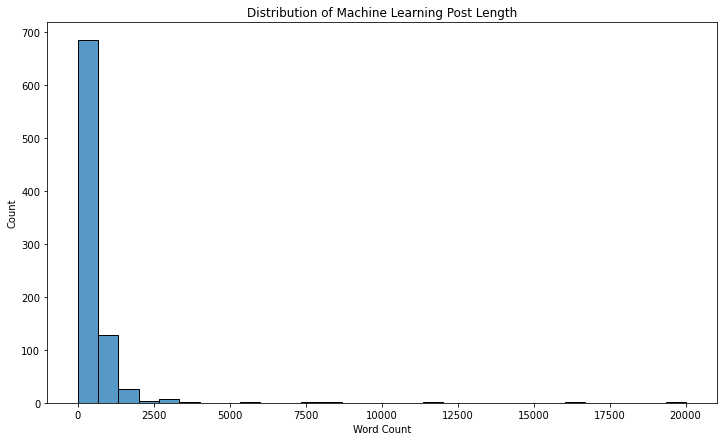

In [26]:
ml_content = subreddit_content[subreddit_content['subreddit'] == 'machinelearning']

# calculate post length
ml_post_length = []

for post in ml_content['post_content']:
    ml_post_length.append(len(post))

# plot histogram
plt.figure(figsize = (12, 7))
sns.histplot(ml_post_length, bins = 30)
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Distribution of Machine Learning Post Length')
plt.show()

While the post length for machine learning posts is observed to also be positively-skewed (like that of the distribution for statistics posts), it has a considerably higher skew. Most of the machine learning posts have a word count of up to 1,000 and a few significantly longer posts with more than 5,000 words, in contrast with the statistics posts where the longest post max out at 3,500 words.

#### Addressing problem statement with the scraped data

From the earlier EDA efforts on statistics and machine learning subreddit posts, we observe the following:
- Commonly used words are contextually related to the respective subreddit topics
- Word count of posts belonging to the machine learning subreddit is relatively longer than that of the posts under the statistics subreddit

Furthermore, the summary statistics shown at the beginning shows that the scraped posts used for this analysis have content which are generally upvoted by the respective communities, indicating relevancy and meaningfulness. Thus, the problem statement can be addressed with the text data collected.

### c. Convert categorical labels of 'statistics' and 'machinelearning' into numerical labels

In [27]:
# convert the categorical labels of 'statistics' and 'machinelearning' into numerical labels
# define mapping
mapping = {'statistics': '0', 'machinelearning': '1'}

# replace categorical labels
subreddit_content['subreddit'] = subreddit_content['subreddit'].map(mapping)

### d. Save df as new csv file

In [28]:
subreddit_content.to_csv('../dataset/subreddit_content_final.csv', index = False)